In [56]:
import torch
from torch.utils.data import Dataset

import torchaudio
import torchaudio.transforms

import torchvision


import sys, os

from pprint import pprint

from tqdm.autonotebook import tqdm

import json

import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display

import pandas as pd

from pathlib import Path

import gc

MANUAL_SEED = 69

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from datetime import date
from datetime import datetime

import os.path
from os import path
  
import json

import time

import copy

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold

import random

from pprint import pformat

import math
import pathlib

from torchaudio_augmentations import * 

from torch.utils.tensorboard import SummaryWriter

In [57]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
print(
  torch.cuda.get_device_name(device) if torch.cuda.is_available() else "cpu"
)

cuda
NVIDIA GeForce RTX 2070


In [59]:
def make_dir_if_absent(dir_path):
  
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    

In [60]:
def random_left_right_truncation(to_truncate, num_els_to_remove):
  clip_left = bool(random.getrandbits(1))

  if clip_left:
    to_truncate = to_truncate[:, : to_truncate.shape[1] - num_els_to_remove]
  else:
    to_truncate = to_truncate[:, num_els_to_remove :]

  return to_truncate

In [61]:
def random_left_right_pad(to_pad, num_els_to_pad):
  
  pad_left = bool(random.getrandbits(1))

  rand_pad = torch.rand((1, num_els_to_pad))

  if pad_left:
    to_pad = torch.cat((rand_pad, to_pad), dim=1)
  else:
    to_pad = torch.cat((to_pad, rand_pad), dim=1)

  return to_pad

In [62]:
def adjust_audio_dimension(to_adjust, target_dimension):

  current_dimension = to_adjust.shape[1]

  if current_dimension > target_dimension:
    
    return random_left_right_truncation(
      to_truncate=to_adjust, 
      num_els_to_remove=current_dimension - target_dimension
    )
  
  if current_dimension < target_dimension:
    
    return random_left_right_pad(
      to_pad=to_adjust,
      num_els_to_pad=target_dimension - current_dimension
    )

  return to_adjust

In [63]:
class RandomSpeedChange:
  def __init__(self, sample_rate, original_audio_len):
    self.sample_rate = sample_rate
    self.POSSIBLE_SPEED_FACTORS = [0.9, 1.0, 1.1]
    self.original_audio_len = original_audio_len

  def __call__(self, audio_data):

    speed_factor = random.choice(self.POSSIBLE_SPEED_FACTORS)

    if speed_factor == 1.0: # no change
      return audio_data

    # change speed and resample to original rate:
    sox_effects = [
      ["speed", str(speed_factor)],
      ["rate", str(self.sample_rate)],
    ]

    transformed_audio, _ = torchaudio.sox_effects.apply_effects_tensor(
      audio_data, self.sample_rate, sox_effects
    )

    transformed_audio = adjust_audio_dimension(
      to_adjust=transformed_audio, target_dimension=self.original_audio_len
    )

    return transformed_audio

  def __repr__(self):
    
    return str(
      {
        "transform_name": "RandomSpeedChange",
        "possible_speed_factors": self.POSSIBLE_SPEED_FACTORS
      }
    )

In [64]:
class RandomBackgroundNoise:
  def __init__(
    self, sample_rate, noise_list, random_noise_n, random_noise_probs,
    noise_num_samples_per_second, noise_num_channels,
    min_snr_db=0, max_snr_db=15, 
  ):
    self.sample_rate = sample_rate
    self.min_snr_db = min_snr_db
    self.max_snr_db = max_snr_db
    self.noise_files_list = noise_list
    self.random_noise_probs = random_noise_probs
    self.random_noise_n = random_noise_n
    self.noise_num_samples_per_second = noise_num_samples_per_second, 
    self.noise_num_channels = noise_num_channels 

  def __call__(self, audio_data):

    random_dice = np.random.choice(
      self.random_noise_n, 1, p=self.random_noise_probs
    )

    if random_dice != 1:
      return audio_data
    
    random_noise_file = random.choice(self.noise_files_list)
    
    effects = [
      ['remix', '1'], # convert to mono
      ['rate', str(self.sample_rate)], # resample
    ]
    
    noise, _ = torchaudio.sox_effects.apply_effects_file(
      random_noise_file, effects, normalize=True
    )
    
    audio_length = audio_data.shape[-1]
    noise_length = noise.shape[-1]
    
    if noise_length > audio_length:
      offset = random.randint(0, noise_length-audio_length)
      noise = noise[..., offset:offset+audio_length]
    
    elif noise_length < audio_length:
      noise = torch.cat(
        [
          noise, 
          torch.zeros((noise.shape[0], audio_length-noise_length))
        ], 
      dim=-1
    )

    snr_db = random.randint(self.min_snr_db, self.max_snr_db)
    snr = math.exp(snr_db / 10)
    
    audio_power = audio_data.norm(p=2)
    noise_power = noise.norm(p=2)
    scale = snr * noise_power / audio_power

    return (scale * audio_data + noise ) / 2

  def __repr__(self):
    
    return str(
      {
        "transform_name": "RandomBackgroundNoise",
        "noise_dataset": "MUSAN",
        "min_snr_db": self.min_snr_db, 
        "max_snr_db": self.max_snr_db,
        "random_noise_n": self.random_noise_n,
        "random_noise_probs": self.random_noise_probs,
        "noise_num_samples_per_second": self.noise_num_samples_per_second,
        "noise_num_channels": self.noise_num_channels
      }
    )

In [65]:
class ComposeTransform:
    def __init__(self, transforms, p_boosting_factors, epoch_steps):
        self.transforms = transforms
        self.p_boosting_factors = p_boosting_factors 
        self.epoch_steps = epoch_steps

        self.step_has_been_called_once = False

    def step(self, epoch):

        if self.epoch_steps is not None and epoch in self.epoch_steps:

            if not self.step_has_been_called_once:
                
                self.pbar_step_desc = tqdm(
                    total=0, position=4, bar_format='{desc}'
                )

                self.pbar_step_desc.set_description_str(
                    f"ComposeTransform.p = {-1}"
                )

                self.step_has_been_called_once = True
            
            for t, i in zip(self.transforms, range(len(self.transforms))):
                if "RandomApply" in t.__class__.__name__:

                    try:
                        t.p = self.p_boosting_factors[epoch]

                        # if i == 0:
                        self.pbar_step_desc.set_description_str(
                            f"ComposeTransform.p = {t.p}"
                        )
                
                        # print(self.epoch_steps[epoch], t.p)
                    
                    except Exception as e:

                        print("Caught the following exception, continuing to whatever comes next!")
                        print(e)

                        pass

    def __call__(self, audio_data):
        for t in self.transforms:
            audio_data = t(audio_data)
        return audio_data
    
    def __repr__(self):
        repr_list = []

        for t in self.transforms:
            repr_list.append(t.__repr__())

        repr_list.append(
            {
                "p_boosting_factors": self.p_boosting_factors,
                "epoch_steps": self.epoch_steps
            }
        )

        return str(repr_list)

In [66]:
class IdentityTransform:
  def __init__(self):
    pass

  def __call__(self, audio_data):
    return audio_data

  def __repr__(self):
    
    return str( { "transform_name": "IdentityTransform" } )

In [67]:
class StandardizeTransform:
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, audio_data):

    return (audio_data - self.mean) / self.std

  def __repr__(self):
    
    return str(
      {
        "transform_name": "StandardizeTransform",
        "mean": self.mean,
        "std": self.std 
      }
    )

In [68]:
class FMADataset(Dataset):

  def __init__(
    self, path, data_transforms_train, data_transforms_eval, data_type
  ):
    self.path = path
    self.data_type = data_type,
    self.stage = None
    self.data_transforms_train = data_transforms_train
    self.data_transforms_eval = data_transforms_eval
    self.data_paths = self._load_audio_list()

  def __len__(self):
    return len(self.data_paths)

  def __getitem__(self, idx):

    data = torch.load(self.data_paths[idx])

    if self.stage == "train" and self.data_transforms_train is not None:
      data = self.data_transforms_train(data)

    if (
      self.stage == "val" or self.stage == "test"
    ) and self.data_transforms_eval is not None:
      data = self.data_transforms_eval(data)

    label_one_hot = self._label_from_str_to_one_hot(
      self.data_paths[idx].split("/")[-2]
    )

    return data, label_one_hot

  
  def _label_from_str_to_one_hot(self, label_str: str): 
  
    if label_str == "Pop":
      return torch.tensor([1, 0, 0, 0, 0, 0]).float()
    
    if label_str == "Hip-Hop":
      return torch.tensor([0, 1, 0, 0, 0, 0]).float()
    
    if label_str == "Electronic":
      return torch.tensor([0, 0, 1, 0, 0, 0]).float()
    
    if label_str == "Rock":
      return torch.tensor([0, 0, 0, 1, 0, 0]).float()

    if label_str == "Folk":
      return torch.tensor([0, 0, 0, 0, 1, 0]).float()

    if label_str == "Jazz":
      return torch.tensor([0, 0, 0, 0, 0, 1]).float()
    
  
  def _load_audio_list(self):
    
    audio_path_list = []
    
    for path, subdirs, files in os.walk(self.path):
      for name in files:
          
        file_audio_path = os.path.join(path, name)
        
        audio_path_list.append(file_audio_path)

    return sorted(audio_path_list, reverse=True)
        
        

In [69]:
DATASET_SIZE = "s"
DATASET_TYPE = "waveform"
DATASET_FOLDER = f"./data/{DATASET_TYPE}"

DATASET_NUM_SAMPLES_PER_SECOND = 8000
DATASET_NUM_CHANNELS = 1

DATASET_NAME = f"fma_{DATASET_SIZE}_resampled_{DATASET_NUM_SAMPLES_PER_SECOND}_rechanneled_{DATASET_NUM_CHANNELS}"

dataset_path = f"{DATASET_FOLDER}/{DATASET_NAME}"

SUMMARY_STATISTICS_PATH = f"./data/summary_statistics/{DATASET_NAME}/{DATASET_NAME}_summary_statistics.json"

In [70]:
summary_statistics_json = open(SUMMARY_STATISTICS_PATH)

summary_statistics_dict = json.load(summary_statistics_json)

In [71]:
ORIGINAL_AUDIO_LENS = {
  (8000, 1): 238000
}

NOISE_NUM_SAMPLES_PER_SECOND = 16000
NOISE_NUM_CHANNELS = 1

NOISE_SIZE = "xs"

NOISE_DIR = f"./data/musan_{NOISE_SIZE}_resampled_{NOISE_NUM_SAMPLES_PER_SECOND}_rechanneled_{NOISE_NUM_CHANNELS}/"
noise_list = list(pathlib.Path(NOISE_DIR).glob('**/*.wav'))

RANDOM_NOISE_N = 2
RANDOM_NOISE_PROBS = [1 / RANDOM_NOISE_N] * RANDOM_NOISE_N

In [72]:
NOISE_DIR

'./data/musan_xs_resampled_16000_rechanneled_1/'

In [73]:
random_speed_change_transform = RandomSpeedChange(
  sample_rate=DATASET_NUM_SAMPLES_PER_SECOND,
  original_audio_len=ORIGINAL_AUDIO_LENS[
    (DATASET_NUM_SAMPLES_PER_SECOND, DATASET_NUM_CHANNELS)
  ]
) 

random_background_noise_transform = RandomBackgroundNoise(
  sample_rate=DATASET_NUM_SAMPLES_PER_SECOND,
  noise_list=noise_list,
  random_noise_n=RANDOM_NOISE_N,
  random_noise_probs=RANDOM_NOISE_PROBS,
  noise_num_channels=NOISE_NUM_CHANNELS,
  noise_num_samples_per_second=NOISE_NUM_SAMPLES_PER_SECOND
)

identity_transform = IdentityTransform()

standardize_transform = StandardizeTransform(
  mean=summary_statistics_dict[f"{DATASET_TYPE}_mean"],
  std=summary_statistics_dict[f"{DATASET_TYPE}_std"]
)

In [74]:
COMPOSE_TRANSFORMS_P_BOOSTING_FACTORS = np.pad(
  np.linspace(0.05, 0.1, 89), (30,0), "constant"
).tolist()

# ascent = np.linspace(0.1, 0.25, 16)
# descent = np.linspace(0.25, 0.15, 66)
# middle = np.hstack((ascent, descent))
# COMPOSE_TRANSFORMS_P_BOOSTING_FACTORS = np.pad(
#   middle, (17,0), "constant", 
# ).tolist()

# COMPOSE_TRANSFORMS_P_BOOSTING_FACTORS = None
# COMPOSE_TRANSFORMS_P_BOOSTING_FACTORS = np.linspace(5, 10, 199)
print(COMPOSE_TRANSFORMS_P_BOOSTING_FACTORS)

print(len(COMPOSE_TRANSFORMS_P_BOOSTING_FACTORS) if COMPOSE_TRANSFORMS_P_BOOSTING_FACTORS is not None else " ")

COMPOSE_TRANSFORMS_EPOCH_STEPS = list(range(1, 199))
# COMPOSE_TRANSFORMS_EPOCH_STEPS = None 

COMPOSE_TRANSFORMS_P = 0.10


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.05056818181818182, 0.05113636363636364, 0.051704545454545454, 0.052272727272727276, 0.05284090909090909, 0.05340909090909091, 0.05397727272727273, 0.05454545454545455, 0.055113636363636365, 0.055681818181818186, 0.05625, 0.05681818181818182, 0.05738636363636364, 0.05795454545454546, 0.058522727272727275, 0.0590909090909091, 0.05965909090909091, 0.06022727272727273, 0.06079545454545455, 0.06136363636363637, 0.061931818181818185, 0.0625, 0.06306818181818183, 0.06363636363636364, 0.06420454545454546, 0.06477272727272727, 0.06534090909090909, 0.06590909090909092, 0.06647727272727273, 0.06704545454545455, 0.06761363636363638, 0.06818181818181819, 0.06875, 0.06931818181818182, 0.06988636363636364, 0.07045454545454546, 0.07102272727272728, 0.0715909090909091, 0.07215909090909092, 0.07272727272727274, 0.07329545454545455, 0.0738636363636

In [75]:
fma_data_transforms_train = ComposeTransform(
  transforms=[ 
    # identity_transform,
    standardize_transform,
    # random_speed_change_transform,
    # random_background_noise_transform

    RandomApply([PolarityInversion()], p=COMPOSE_TRANSFORMS_P),
    RandomApply([Noise(min_snr=0.001, max_snr=0.005)], p=COMPOSE_TRANSFORMS_P),
    RandomApply([Gain()], p=COMPOSE_TRANSFORMS_P),  
    # RandomResizedCrop(n_samples=2), # shape error :(
    RandomApply([Delay(sample_rate=DATASET_NUM_SAMPLES_PER_SECOND)], p=COMPOSE_TRANSFORMS_P),
    # RandomApply([PitchShift(
    #   n_samples=5*DATASET_NUM_SAMPLES_PER_SECOND,
    #   sample_rate=DATASET_NUM_SAMPLES_PER_SECOND
    # )], p=0.2), # very very computationally expensive :(
    # RandomApply([Reverb(sample_rate=DATASET_NUM_SAMPLES_PER_SECOND)], p=COMPOSE_TRANSFORMS_P) # very computationally expensive :(
  ], 
  p_boosting_factors=COMPOSE_TRANSFORMS_P_BOOSTING_FACTORS, 
  epoch_steps=COMPOSE_TRANSFORMS_EPOCH_STEPS
)

fma_data_transforms_eval = ComposeTransform(
  transforms=[standardize_transform],
  p_boosting_factors=None, 
  epoch_steps=None
)

In [76]:
fma_dataset = FMADataset(
  path=dataset_path, 
  data_transforms_train=fma_data_transforms_train,
  data_transforms_eval=fma_data_transforms_eval,
  data_type=DATASET_TYPE
)

In [77]:
TRAIN_VAL_PERCENTAGE = 0.9

full_size = len(fma_dataset)
train_val_size = int(TRAIN_VAL_PERCENTAGE * full_size)
test_size = full_size - train_val_size

In [78]:
generator=torch.Generator().manual_seed(MANUAL_SEED)

fma_dataset_train_val, fma_dataset_test = torch.utils.data.random_split(
  fma_dataset, [train_val_size, test_size], generator
)

In [79]:
TRAIN_PERCENTAGE = 0.8

full_size = train_val_size
train_size = int(TRAIN_PERCENTAGE * full_size)
val_size = full_size - train_size

In [80]:
fma_dataset_train, fma_dataset_val = torch.utils.data.random_split(
  fma_dataset_train_val, [train_size, val_size], generator
)

In [81]:
# print(f"len(fma_dataset_train): {len(fma_dataset_train)}")
# print(f"len(fma_dataset_val)  : {len(fma_dataset_val)}")
# print(f"len(fma_dataset_test) : {len(fma_dataset_test)}")

In [82]:
BATCH_SIZE = 16
NUM_WORKERS = 16

data_logs = {
  "data_type": DATASET_TYPE,
  "dataset_size": DATASET_SIZE,
  "batch_size": BATCH_SIZE,
  "num_samples_per_second": DATASET_NUM_SAMPLES_PER_SECOND,
  "num_channels": DATASET_NUM_CHANNELS,
  "data_transforms_train": fma_data_transforms_train
}

In [83]:
fma_dataloader_train = torch.utils.data.DataLoader(
  fma_dataset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, 
  generator=generator
)
fma_dataloader_val = torch.utils.data.DataLoader(
  fma_dataset_val, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, 
  generator=generator
)
fma_dataloader_test = torch.utils.data.DataLoader(
  fma_dataset_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, 
  generator=generator
)

In [84]:
def count_num_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [85]:
def gen_train_id():
  return datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [86]:
def save_dict_to_disk(dict, full_path):

  make_dir_if_absent("/".join(full_path.split("/")[:-1]))

  with open(full_path, 'w') as fp:
    json.dump(dict, fp)

def load_dict_from_disk(full_path):
  
  with open(full_path) as json_file:
    dict_from_disk = json.load(json_file)
  
  return dict_from_disk

In [87]:
def store_ckp(
  model, optimizer, ckp_dir, ckp_name, epoch, loss_train, loss_val, loss_test
):

  model_copy = copy.deepcopy(model)
  
  full_path_pickle = f"{ckp_dir}/{ckp_name}_epoch_{epoch}.pth"
  
  make_dir_if_absent(dir_path="/".join(full_path_pickle.split('/')[:-1]))
  
  torch.save(
    {
      'epoch': epoch,
      'model_state_dict': model_copy.cpu().state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss_train': loss_train,
      'loss_val': loss_val,
      'loss_test': loss_test,
    }, 
    full_path_pickle
  )
  
  torch.save(
    model_copy.cpu(), 
    full_path_pickle
  )

In [88]:
def load_ckp(ckp_path, perform_loading_sanity_check):

  loaded_model = torch.load(ckp_path)

  if perform_loading_sanity_check:

    loaded_model.eval()

    sanity_check_out = loaded_model(torch.rand((16, 1, 238000)))

  return loaded_model

In [89]:
def get_num_correct_preds(outputs, labels):
  
  output_pred_ind = torch.argmax(outputs, dim=1)
  labels_ind = torch.argmax(labels, dim=1)
  
  matching_mask = (output_pred_ind == labels_ind).float()
  
  num_correct_preds = matching_mask.sum()
  
  return num_correct_preds

In [90]:
def train_model(
  model, optimizer, criterion,
  batch_size, train_dl, val_dl, test_dl, 
  num_epochs, 
  lr_scheduler,
  device, 
  print_freq, ckp_freq, 
  ckp_dir, ckp_name,
  should_close_tqdm_prog_bars_when_done,
  limit_num_batches=None
):

  train_id = gen_train_id()
  
  training_logs = {
    "train_id": train_id,
    "accuracies": {},
    "losses": {}
  }

  writer = SummaryWriter()
  
  model = model.to(device)
  
  pbar_epochs = tqdm(range(num_epochs), colour="#9400d3", position=1)
  pbar_batches_train = tqdm(
    iter(train_dl), colour="#4169e1", leave=False, position=4
  )
  pbar_batches_val = tqdm(
    iter(val_dl), colour="#008080", leave=False, position=5
  )
  pbar_best_epoch_desc = tqdm(
    total=0, position=2, bar_format='{desc}', colour="green"
  )
  pbar_epoch_desc = tqdm(
    total=0, position=3, bar_format='{desc}', colour="#9400d3"
  )
  
  training_start_time = time.time()

  best_loss_val = np.Inf

  for epoch in range(num_epochs):

    running_loss_train = 0.0
    running_loss_val   = 0.0
    running_loss_test  = -1.0
    
    num_correct_preds_train = 0.0
    num_preds_train = 0.0
    accuracy_train = 0.0
    
    num_correct_preds_val = 0.0
    num_preds_val = 0.0
    accuracy_val = 0.0
    
    num_correct_preds_test = 0.0
    num_preds_test = 0.000000001
    accuracy_test = 0.0

    num_batches = 0
        
    ## BEGIN training step
    
    model.train()

    train_dl.dataset.dataset.stage="train"
    train_dl.dataset.dataset.data_transforms_train.step(epoch=epoch)
    
    pbar_batches_train.reset()
    pbar_batches_val.reset()
    
    pbar_epochs.set_description(f"epoch {epoch}")
    pbar_batches_train.set_description(f"epoch {epoch}")
    pbar_batches_val.set_description  (f"epoch {epoch}")
    
    for batch_x, batch_y in iter(train_dl):

      if limit_num_batches is not None and num_batches <= limit_num_batches:

        inputs, labels = batch_x, batch_y
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = outputs.squeeze(-1)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item() * batch_x.shape[0]
        
        num_correct_preds_train += get_num_correct_preds(outputs, labels)
        num_preds_train += outputs.shape[0]
      
      num_batches += 1
      
      pbar_batches_train.update(1)
      
    
    ## END training step
    
    ## BEGIN validation step
    
    with torch.no_grad():
      
      model.eval()

      train_dl.dataset.dataset.stage="val"
      
      for batch_x, batch_y in iter(val_dl):

        inputs, labels = batch_x, batch_y
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        outputs = outputs.squeeze(-1)
        
        loss = criterion(outputs, labels)
        
        running_loss_val += loss.item() * batch_x.shape[0]
        
        num_correct_preds_val += get_num_correct_preds(outputs, labels)
        num_preds_val += outputs.shape[0]
        
        pbar_batches_val.update(1)
        
    ## END validation step

    if "ReduceLROnPlateau" in lr_scheduler.__class__.__name__:
      lr_scheduler.step(running_loss_train) 
    else:
      lr_scheduler.step()
    
    ## BEGIN test step
    
    if (epoch + 1 == num_epochs):
      
      pbar_batches_test = tqdm(
        iter(test_dl), colour="#808000", leave=False,
      )
      pbar_batches_test.set_description  (f"epoch {epoch}")
    
      with torch.no_grad():
        
        model.eval()

        train_dl.dataset.dataset.stage="test"
        
        for batch_x, batch_y in iter(test_dl):

          inputs, labels = batch_x, batch_y
          inputs, labels = inputs.to(device), labels.to(device)
          
          outputs = model(inputs)
          outputs = outputs.squeeze(-1)
          
          loss = criterion(outputs, labels)
          
          running_loss_test += loss.item() * batch_x.shape[0]
          
          num_correct_preds_test += get_num_correct_preds(outputs, labels)
          num_preds_test += outputs.shape[0]
          
          pbar_batches_test.update(1)
        
    ## END test step
    
    accuracy_train = num_correct_preds_train / num_preds_train
    accuracy_val = num_correct_preds_val / num_preds_val
    accuracy_test = num_correct_preds_test / num_preds_test
    
    training_logs["accuracies"][str(epoch)] = {
      "accuracy_train": accuracy_train.cpu().item(),
      "accuracy_val": accuracy_val.cpu().item(),
    }
    training_logs["losses"][str(epoch)] = {
      "loss_train": running_loss_train,
      "loss_val": running_loss_val,
    }

    writer.add_scalar("loss_train", running_loss_train, epoch)
    writer.add_scalar("loss_val", running_loss_val, epoch)
    writer.add_scalar("accuracy_val", accuracy_val, epoch)

    
    # if ((epoch + 1) % print_freq == 0):
    if running_loss_val < best_loss_val:  
      pbar_best_epoch_desc.set_description_str(
        f"[best] epoch: {(str(epoch + 1)).zfill(3)}, " + 
        f"train loss: {str(round(running_loss_train, 2)).zfill(6)}, train acc: {str(round(accuracy_train.cpu().item(), 2))}, " + 
        f"val loss  : {str(round(running_loss_val, 2)).zfill(6)} , val acc  : {str(round(accuracy_val.cpu().item(), 2))}, " + 
        f"val loss delta change: {best_loss_val - running_loss_val}"
      )

      best_loss_val = running_loss_val

    pbar_epoch_desc.set_description_str(
      f"[curr] epoch: {(str(epoch + 1)).zfill(3)}, " + 
      f"train loss: {str(round(running_loss_train, 2)).zfill(6)}, train acc: {str(round(accuracy_train.cpu().item(), 2))}, " + 
      f"val loss  : {str(round(running_loss_val, 2)).zfill(6)} , val acc  : {str(round(accuracy_val.cpu().item(), 2))}"
      
    )

    pbar_epochs.update(1)
    
    if ((epoch + 1) == num_epochs):
      tqdm.write(
        f"epoch: {(str(epoch + 1)).zfill(3)}\n" + 
        f"  train loss: {str(round(running_loss_train, 2)).zfill(6)}, train acc: {str(round(accuracy_train.cpu().item(), 2))}\n" + 
        f"  val loss  : {str(round(running_loss_val, 2)).zfill(6)}, val acc  : {str(round(accuracy_val.cpu().item(), 2))}\n" + 
        f"  test loss : {round(running_loss_test, 2)} , test acc: {round(accuracy_test.cpu().item(), 2)}\n"
      )
      
      training_logs["accuracies"][str(epoch)][
        "accuracy_test"
      ] = accuracy_test.cpu().item()
      
      training_logs["losses"][str(epoch)][
        "loss_test"
      ] = running_loss_test
      
    if (ckp_freq != None and (epoch + 1) % ckp_freq == 0):
      
      store_ckp(
        model=model, optimizer=optimizer, 
        ckp_dir=ckp_dir, ckp_name=ckp_name, epoch=epoch, 
        loss_train=running_loss_train, 
        loss_val=running_loss_val, 
        loss_test=running_loss_test
      )
  
  training_end_time = time.time()

  training_logs["training_time_secs"] = training_end_time - training_start_time

  if (should_close_tqdm_prog_bars_when_done):
    pbar_epochs.container.close()
    pbar_batches_train.close()
    pbar_batches_val.close()
    pbar_batches_test.close()

  writer.flush()
  writer.close()
  
  return training_logs

## CNN

### Design motivations

First layers --> neural compression layers --> dimensionality reduction to roughly match dimensions of this paper https://arxiv.org/pdf/1703.01789.pdf

Mid and final layers --> taken 1:1 from the paper linked above

Batch norm placed BEFORE the activation function, as described in the og paper https://arxiv.org/abs/1502.03167 and explained by Bengio in his DL book https://www.deeplearningbook.org/contents/optimization.html in section 8.7.1

Dropout placed according to the og paper: https://arxiv.org/pdf/1207.0580.pdf

In [91]:
class CNN(nn.Module):
  def __init__(
    self, 
    num_layers, 
    kernel_sizes, strides, 
    in_channels, num_filters,
    pool_sizes, pool_strides,
    dropout_p_conv, dropout_p_linear
  ):
    super().__init__()

    self.num_layers = num_layers 
    self.kernel_sizes = kernel_sizes 
    self.strides = strides 
    self.in_channels = in_channels 
    self.num_filters = num_filters
    self.pool_sizes = pool_sizes 
    self.pool_strides = pool_strides
    
    self.dropout_p_conv = dropout_p_conv
    self.dropout_p_linear = dropout_p_linear

    self.bns = {
      "1": nn.BatchNorm1d(num_features=1),
      "2": nn.BatchNorm1d(num_features=2),
      "4": nn.BatchNorm1d(num_features=4),
      "6": nn.BatchNorm1d(num_features=6),
      "8": nn.BatchNorm1d(num_features=8),
      "16": nn.BatchNorm1d(num_features=16),
      "32": nn.BatchNorm1d(num_features=32),
      "64": nn.BatchNorm1d(num_features=64),
      "128": nn.BatchNorm1d(num_features=128),
      "256": nn.BatchNorm1d(num_features=256),
      "512": nn.BatchNorm1d(num_features=512)
    }
    
    self.neural_network = nn.Sequential()
    
    for i in range(num_layers):
      
      conv_layer = nn.Conv1d(
        kernel_size=self.kernel_sizes[i],
        stride=self.strides[i],
        in_channels=in_channels,
        out_channels=self.num_filters[i]
      )
      torch.nn.init.xavier_uniform_(conv_layer.weight)

      
      pooling_layer = nn.MaxPool1d(
        kernel_size=self.pool_sizes[i],
        stride=self.pool_strides[i],
      )
      
      in_channels = self.num_filters[i]
      
      self.neural_network.add_module(name=f"conv_{i}", module=conv_layer)
      
      self.neural_network.add_module(name=f"pool_{i}", module=pooling_layer)
        
      self.neural_network.add_module(
        name=f"batchnorm_{i}", 
        module=nn.BatchNorm1d(num_features=self.num_filters[i])
      )
      
      if (i < num_layers - 1):
        
        self.neural_network.add_module(name=f"activ_{i}", module=nn.ReLU())

      else:
        
        self.neural_network.add_module(name=f"activ_{i}", module=nn.Sigmoid())

      # if (i < num_layers - 2):

      #   self.neural_network.add_module(
      #     name=f"dropout_{i}", module=nn.Dropout(p=self.dropout_p_conv))
        
      if (i == num_layers - 2):

        self.neural_network.add_module(
          name=f"dropout_{i}", module=nn.Dropout(p=self.dropout_p_linear)
        )
  
  def forward(self, x):    
    x = self.neural_network(x)

    return x

  def get_model_setup(self):
    
    return {
      "num_layers": self.num_layers, 
      "kernel_sizes": self.kernel_sizes, 
      "strides": self.strides, 
      "in_channels": self.in_channels, 
      "num_filters": self.num_filters,
      "pool_sizes": self.pool_sizes, 
      "pool_strides": self.pool_strides,
      "dropout_p_conv": self.dropout_p_conv,
      "dropout_p_linear": self.dropout_p_linear,
    }

In [92]:
def plot_loss_curves(stats):
  epochs = stats["training_logs"]["losses"].keys()
  
  loss_train = [
    j["loss_train"] for j in stats["training_logs"]["losses"].values()
  ]
  
  loss_val = [j["loss_val"] for j in stats["training_logs"]["losses"].values()]

  sns.lineplot(
    x=epochs,
    y=loss_train,
    legend="full",
    label="train loss"
  )

  sns.lineplot(
    x=epochs,
    y=loss_val,
    legend="full",
    label="val loss"
  )

## K-fold cross validation for hyperparameter search

In [93]:
k_fold_cv_num_layers = 5

k_fold_cv_kernel_sizes =[64, 32, 16,   8,   4]
k_fold_cv_pool_sizes   =[ 8,  8,  2,   2,   4]
k_fold_cv_strides      =[ 3,  3,  2,   2,   2]
k_fold_cv_pool_strides =[ 8,  8,  2,   4,   2]
# k_fold_cv_num_filters  =[16, 32, 64,  128,   6]
# k_fold_cv_num_filters  =[14, 18, 18,  22,   6]
k_fold_cv_num_filters  =[22, 24, 26,  28,   6]
# k_fold_cv_num_filters = [80, 112, 128, 160,   6]

k_fold_cv_in_channels   = 1 if DATASET_TYPE == "waveform" else 2

K_FOLD_CV_DROPOUT_P_CONV = 0.0
K_FOLD_CV_DROPOUT_P_LINEAR = 0.5

In [94]:
def cnn_factory(
  num_layers,
  kernel_sizes,
  strides,
  in_channels,
  num_filters,
  pool_sizes,
  pool_strides,
  dropout_p_conv, 
  dropout_p_linear
):
  return CNN(
  num_layers=num_layers,
  kernel_sizes=kernel_sizes, 
  strides=strides, 
  in_channels=in_channels, 
  num_filters=num_filters,
  pool_sizes=pool_sizes,
  pool_strides=pool_strides,
  dropout_p_conv=dropout_p_conv,
  dropout_p_linear=dropout_p_linear
)

In [95]:
LR = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-3
OPTIMIZER_NAME = "SGD"

In [96]:
def optimizer_factory(optimizer_name, model, lr, momentum, weight_decay):

  if optimizer_name == "SGD":
    optimizer = optim.SGD(
      model.parameters(), 
      lr=lr, 
      momentum=momentum,
      nesterov=True,
      weight_decay=weight_decay
    )

    optimizer_config = {
    "lr": lr, 
    "momentum": momentum, 
    "weight_decay": weight_decay,
    "nesterov": True
  }  

  elif optimizer_name == "Adam":

    optimizer = optim.Adam(
      model.parameters(),
      lr=lr,
      weight_decay=weight_decay
    )

    optimizer_config = {
    "lr": lr, 
    "weight_decay": weight_decay
  }  
    

  return optimizer, optimizer_config


In [97]:
def step_lr_factory(optimizer, step_size, gamma, last_epoch, verbose):
  return torch.optim.lr_scheduler.StepLR(
    optimizer, step_size, gamma, last_epoch, verbose
  )

In [98]:
def reduce_lr_on_plateau_factory(
  optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, 
  threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False
):
  return torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode=mode, factor=factor, patience=patience, 
    threshold=threshold, threshold_mode=threshold_mode, cooldown=cooldown, 
    min_lr=min_lr, eps=eps, verbose=verbose
  )

In [99]:
K_FOLD_CV_NUM_FOLDS = 3
K_FOLD_CV_LIMIT_NUM_FOLDS = 1

K_FOLD_CV_BATCH_SIZE = 64
K_FOLD_CV_LIMIT_NUM_BATCHES_PERCENTAGE = 0.6

K_FOLD_CV_NUM_EPOCHS = 119
# K_FOLD_CV_PRINT_FREQ = int(K_FOLD_CV_NUM_EPOCHS * 0.1)
K_FOLD_CV_PRINT_FREQ = 1

K_FOLD_CV_CKP_FREQ = int(K_FOLD_CV_NUM_EPOCHS * 0.1)

K_FOLD_CV_LOGS_FOLDER = f"./k_fold_cv/cnn/{DATASET_TYPE}"

K_FOLD_CV_CKP_FOLDER = K_FOLD_CV_LOGS_FOLDER

K_FOLD_CV_SHOULD_CLOSE_TQDM_PROG_BARS_WHEN_DONE=True

In [100]:
# LR_SCHEDULER_TYPE = "step"
LR_SCHEDULER_TYPE = "reduce_on_plateau"

In [101]:
LR_SCHEDULER_STEP_SIZE = 30
LR_SCHEDULER_GAMMA = 0.02
LR_SCHEDULER_LAST_EPOCH = -1
LR_SCHEDULER_VERBOSE = False

In [102]:
REDUCE_LR_ON_PLATEAU_FACTOR = 0.01

In [103]:
cv_models = [

  cnn_factory(
    num_layers=k_fold_cv_num_layers,
    kernel_sizes=k_fold_cv_kernel_sizes, 
    strides=k_fold_cv_strides, 
    in_channels=k_fold_cv_in_channels, 
    num_filters=k_fold_cv_num_filters,
    pool_sizes=k_fold_cv_pool_sizes,
    pool_strides=k_fold_cv_pool_strides,
    dropout_p_conv=K_FOLD_CV_DROPOUT_P_CONV,
    dropout_p_linear=K_FOLD_CV_DROPOUT_P_LINEAR
  ) for _ in range(0, K_FOLD_CV_NUM_FOLDS)

]

cv_criterions = [nn.CrossEntropyLoss() for _ in range(0, K_FOLD_CV_NUM_FOLDS)]

cv_opts = [
  optimizer_factory(
    optimizer_name=OPTIMIZER_NAME,
    model=cv_models[i],
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
  ) for i in range(0, K_FOLD_CV_NUM_FOLDS)
]

cv_optimizers = [opt for opt, _ in cv_opts]
cv_optimizers_configs = [opt_conf for _, opt_conf in cv_opts]

cv_lr_schedulers = []
for i in range(0, len(cv_optimizers)):
  
  if LR_SCHEDULER_TYPE == "step":
    lr_scheduler = step_lr_factory(
      optimizer=cv_optimizers[i],
      step_size=LR_SCHEDULER_STEP_SIZE,
      gamma=LR_SCHEDULER_GAMMA,
      last_epoch=LR_SCHEDULER_LAST_EPOCH,
      verbose=LR_SCHEDULER_VERBOSE
    )
  
  elif LR_SCHEDULER_TYPE == "reduce_on_plateau":
    lr_scheduler = reduce_lr_on_plateau_factory(
      optimizer=cv_optimizers[i],
      factor=REDUCE_LR_ON_PLATEAU_FACTOR
    )
  
  cv_lr_schedulers.append(lr_scheduler)

cv_lr_schedulers_config = {
  "lr_scheduler_step_size": LR_SCHEDULER_STEP_SIZE,
  "lr_scheduler_gamma": LR_SCHEDULER_GAMMA,
  "lr_scheduler_last_epoch": LR_SCHEDULER_LAST_EPOCH,
}

cv_train_dls = []
cv_val_dls = []
cv_test_dls = []

In [104]:
k_fold = KFold(n_splits=K_FOLD_CV_NUM_FOLDS, shuffle=True)

cv_train_idxs = []

for fold, (train_idxs, val_idxs) in enumerate(k_fold.split(fma_dataset_train_val)):

  train_subsampler = torch.utils.data.SubsetRandomSampler(train_idxs)
  val_subsampler = torch.utils.data.SubsetRandomSampler(val_idxs)

  cv_train_dls.append(
    torch.utils.data.DataLoader(
      fma_dataset_train_val, batch_size=K_FOLD_CV_BATCH_SIZE, sampler=train_subsampler
    )
  )
  cv_train_idxs.append(train_idxs)

  cv_val_dls.append(
    torch.utils.data.DataLoader(
      fma_dataset_train_val, batch_size=K_FOLD_CV_BATCH_SIZE, sampler=val_subsampler
    )
  )

  cv_test_dls.append(
    torch.utils.data.DataLoader(
      fma_dataset_test, batch_size=K_FOLD_CV_BATCH_SIZE
    )
  )

k_fold_cv_limit_num_batches = int(
  len(list(cv_train_dls[0])) * K_FOLD_CV_LIMIT_NUM_BATCHES_PERCENTAGE
) + 1

cv_data_logs = {
  "data_type": DATASET_TYPE,
  "dataset_size": DATASET_SIZE,
  "batch_size": K_FOLD_CV_BATCH_SIZE,
  "num_samples_per_second": DATASET_NUM_SAMPLES_PER_SECOND,
  "num_channels": DATASET_NUM_CHANNELS,
  "train_transforms": fma_data_transforms_train.__repr__()
}

In [105]:
def perform_k_fold_cv(
  cv_id,

  cv_num_folds,
  cv_models, cv_optimizers, cv_criterions,
  batch_size, 
  cv_train_dls, cv_train_idxs, cv_val_dls, cv_test_dls, 
  cv_num_epochs, 
  cv_lr_schedulers,
  cv_device, 
  cv_print_freq, cv_ckp_freq, 
  cv_ckp_dir,
  cv_should_close_tqdm_prog_bars_when_done,
  cv_limit_num_folds,
  cv_limit_num_batches=None
):

  cv_training_logs = {}

  pbar_folds = tqdm(range(cv_num_folds), colour="#b22222")

  for fold in pbar_folds:
    pbar_folds.set_description(f"fold {fold}")

    cv_ckp_fold_dir = f"{cv_ckp_dir}/fold_{fold}"

    if fold < cv_limit_num_folds:

      training_log = train_model(
        model=cv_models[fold], 
        optimizer=cv_optimizers[fold], criterion=cv_criterions[fold],
        batch_size=batch_size,
        train_dl=cv_train_dls[fold], val_dl=cv_val_dls[fold], test_dl=cv_test_dls[fold],
        num_epochs=cv_num_epochs, 
        lr_scheduler=cv_lr_schedulers[fold],
        device=cv_device,
        print_freq=cv_print_freq, ckp_freq=cv_ckp_freq, 
        ckp_dir=cv_ckp_fold_dir, ckp_name=f"{cv_id}_fold_{fold}",
        should_close_tqdm_prog_bars_when_done=cv_should_close_tqdm_prog_bars_when_done,
        limit_num_batches=cv_limit_num_batches
      )

    cv_training_logs[str(fold)] = training_log

    pbar_folds.update(1)

  return cv_training_logs
  
  

In [106]:
def print_k_fold_cv_curves(
  k_fold_cv_stats, curve_name_singular, curve_name_plural, plot_title, 
  limit_to_n_folds=None
):
  
  num_folds = len(list(k_fold_cv_stats["training_logs"].keys()))
  num_folds_og = num_folds
  
  if limit_to_n_folds is not None and limit_to_n_folds <= num_folds:
    num_folds = limit_to_n_folds
  

  for fold in range(0, num_folds):

    fold_str = str(fold)

    losses_dict = k_fold_cv_stats["training_logs"][fold_str][curve_name_plural]

    epochs = losses_dict.keys()
    
    curve_train = [ j[f"{curve_name_singular}_train"] for j in losses_dict.values() ]

    curve_val = [ j[f"{curve_name_singular}_val"] for j in losses_dict.values() ]

    fig, ax = plt.subplots()

    sns.lineplot(
      x=epochs,
      y=curve_train,
      legend="full",
      label=f"train {curve_name_singular}", 
      ax=ax
    )

    sns.lineplot(
      x=epochs,
      y=curve_val,
      legend="full",
      label=f"val {curve_name_singular}", 
      ax=ax
    )

    fig.suptitle(plot_title)
    ax.set_title(f"{num_folds_og}-fold CV, fold {fold + 1}")
    
    epochs_as_list = list(epochs)
    PERCENTAGE_X_AXIS_TICKS = 0.2
    epoch_axis_display = epochs_as_list[
      ::int(len(epochs_as_list) * PERCENTAGE_X_AXIS_TICKS)
    ]
    ax.set_xticklabels(epoch_axis_display)
    ax.set_xticks(epoch_axis_display)

In [107]:
def print_avg_fold_cv_curves(
  k_fold_cv_stats, curve_name_singular, curve_name_plural, plot_title
):
  
  num_folds = len(list(k_fold_cv_stats["training_logs"].keys()))

  curves_train = []
  curves_val = []

  for fold in range(0, num_folds):

    fold_str = str(fold)

    losses_dict = k_fold_cv_stats["training_logs"][fold_str][curve_name_plural]

    epochs = losses_dict.keys()
    
    curves_train.append(
      [ j[f"{curve_name_singular}_train"] for j in losses_dict.values() ]
    )

    curves_val.append(
      [ j[f"{curve_name_singular}_val"] for j in losses_dict.values() ]
    )
  
  curves_train_np = np.asarray(curves_train)
  curves_val_np = np.asarray(curves_val)

  curve_train = np.average(curves_train_np, axis=0)
  curve_val = np.average(curves_val_np, axis=0)

  fig, ax = plt.subplots()

  sns.lineplot(
    x=epochs,
    y=curve_train,
    legend="full",
    label=f"train {curve_name_singular}", 
    ax=ax
  )

  sns.lineplot(
    x=epochs,
    y=curve_val,
    legend="full",
    label=f"val {curve_name_singular}", 
    ax=ax
  )

  fig.suptitle(plot_title)
  
  epochs_as_list = list(epochs)
  PERCENTAGE_X_AXIS_TICKS = 0.2
  epoch_axis_display = epochs_as_list[
    ::int(len(epochs_as_list) * PERCENTAGE_X_AXIS_TICKS)
  ]
  ax.set_xticklabels(epoch_axis_display)
  ax.set_xticks(epoch_axis_display)

  fig, ax =plt.subplots(2, 1)
  sns.lineplot(
    x=epochs,y=curve_train,legend="full",
    label=f"train {curve_name_singular}", ax=ax[0]
  )
  sns.lineplot(
    x=epochs,y=curve_val,legend="full",
    label=f"val {curve_name_singular}", ax=ax[1], color="orange"
  )

  ax[0].set_xticklabels(epoch_axis_display)
  ax[1].set_xticklabels(epoch_axis_display)
  ax[0].set_xticks(epoch_axis_display)
  ax[1].set_xticks(epoch_axis_display)
  fig.show()


In [108]:
K_FOLD_CV_RUN = True

K_FOLD_CV_PRINT_LOSS_CURVES_ACROSS_FOLDS = False
K_FOLD_CV_PRINT_ACC_CURVES_ACROSS_FOLDS  = False

K_FOLD_CV_PRINT_LOSS_CURVES_AVG_FOLDS = True
K_FOLD_CV_PRINT_ACC_CURVES_AVG_FOLDS  = True

K_FOLD_CV_PLOTS_LIMIT_TO_N_FOLDS = 1

K-fold cross-validation ID: 2022_12_12_21_13_14


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 119
  train loss: 1587.14, train acc: 0.68
  val loss  : 1315.77, val acc  : 0.45
  test loss : 447.87 , test acc: 0.42



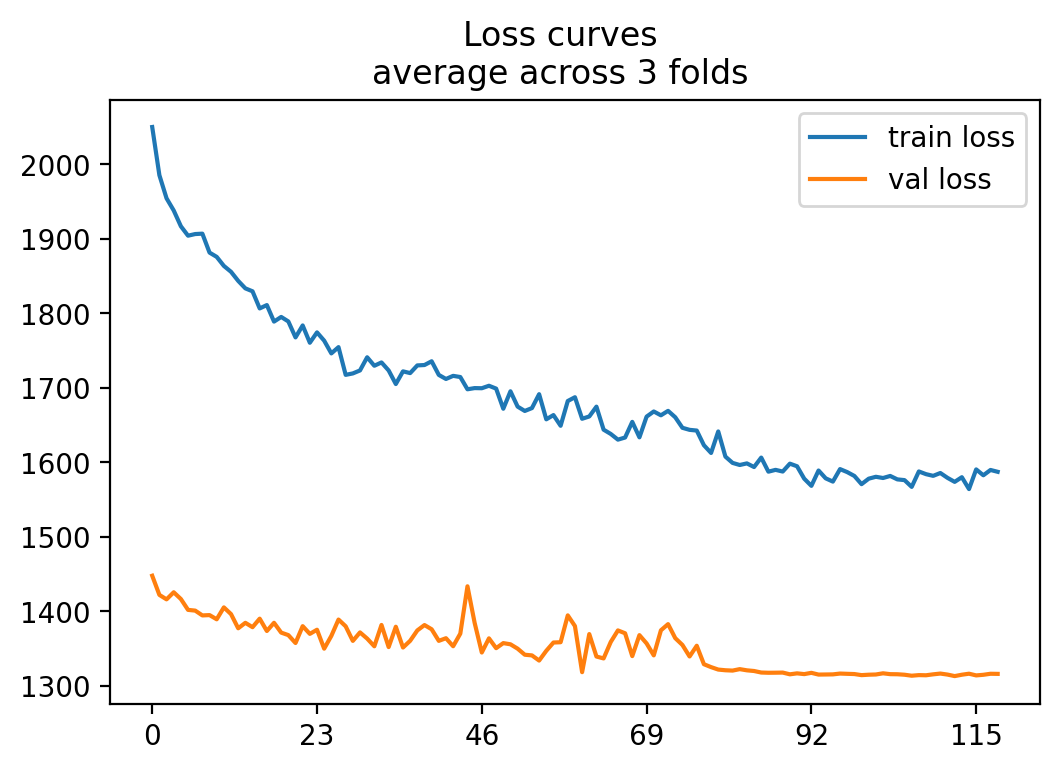

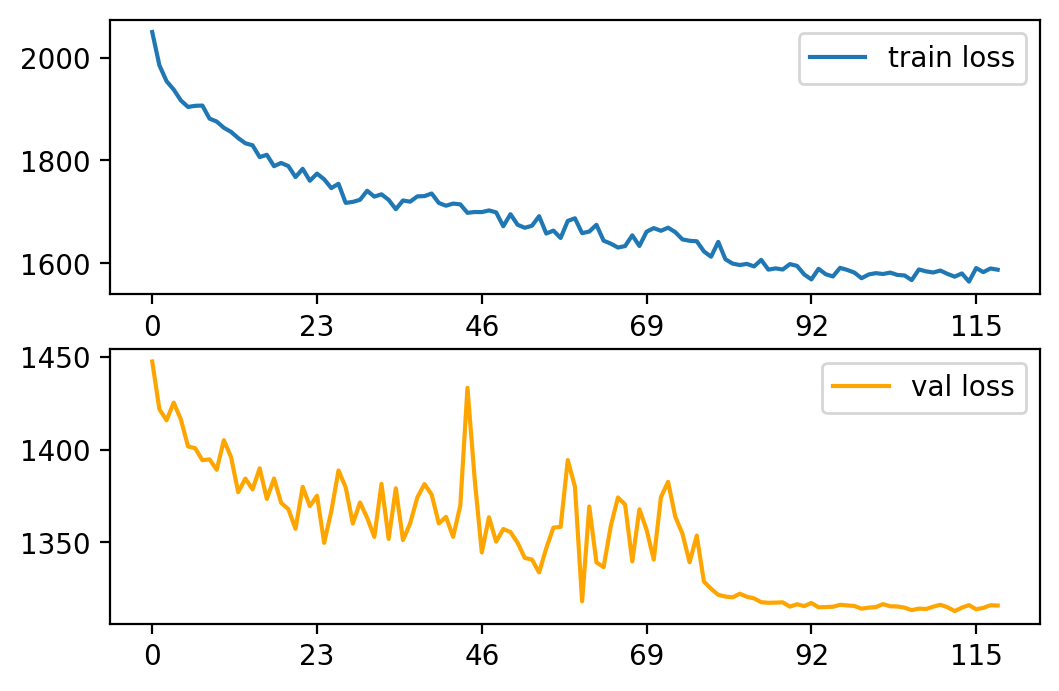

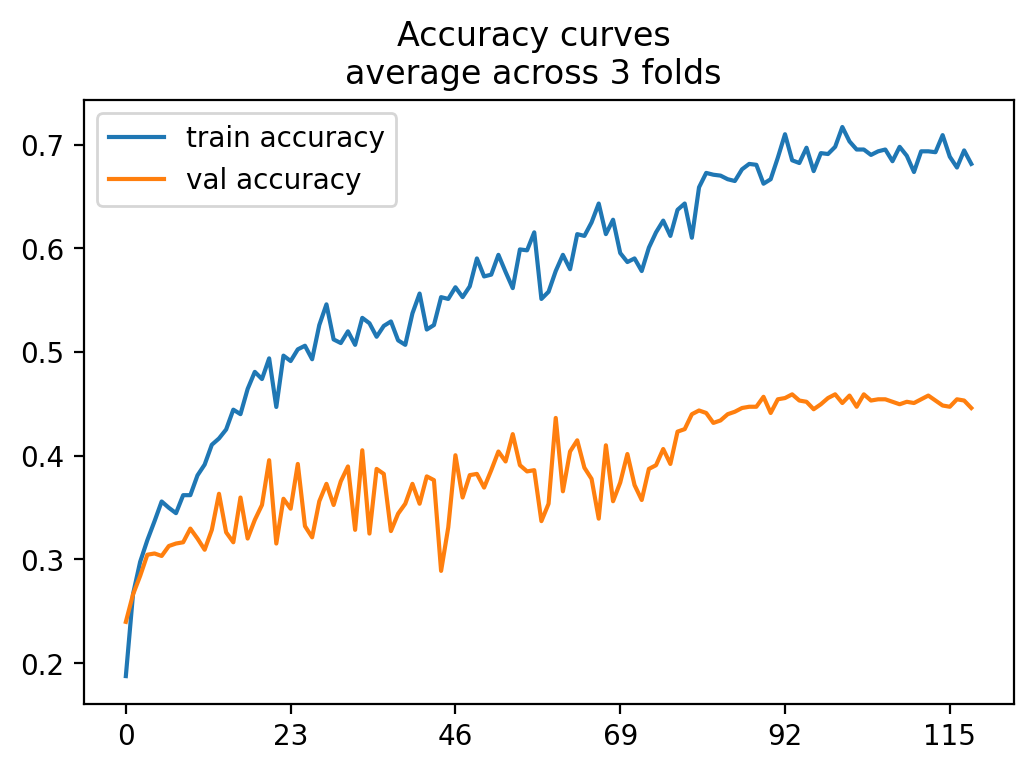

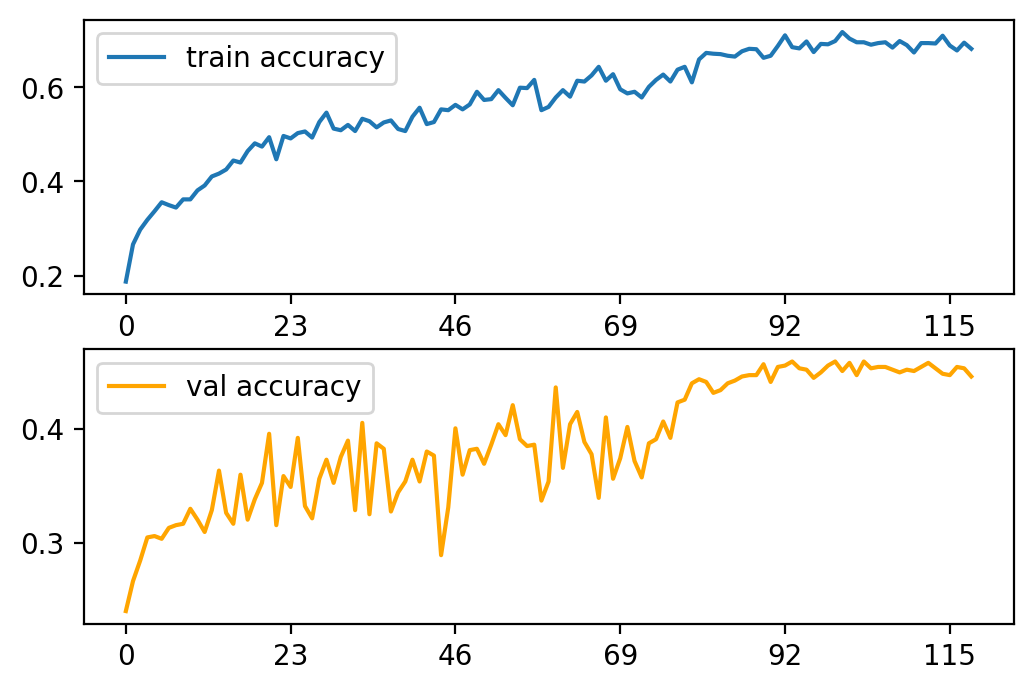

In [109]:
if K_FOLD_CV_RUN:

  k_fold_cv_id = gen_train_id()

  print(f"K-fold cross-validation ID: {k_fold_cv_id}")

  k_fold_cv_training_logs = perform_k_fold_cv(
    cv_id=k_fold_cv_id,
    cv_num_folds=K_FOLD_CV_NUM_FOLDS,
    cv_models=cv_models, cv_optimizers=cv_optimizers, cv_criterions=cv_criterions,
    batch_size=K_FOLD_CV_BATCH_SIZE, 
    cv_train_dls=cv_train_dls, cv_train_idxs=cv_train_idxs, 
    cv_val_dls=cv_val_dls, cv_test_dls=cv_test_dls,
    cv_num_epochs=K_FOLD_CV_NUM_EPOCHS, 
    cv_lr_schedulers=cv_lr_schedulers,
    cv_device=device, 
    cv_print_freq=K_FOLD_CV_PRINT_FREQ, cv_ckp_freq=K_FOLD_CV_CKP_FREQ, 
    cv_ckp_dir=f"{K_FOLD_CV_CKP_FOLDER}/{k_fold_cv_id}",
    cv_should_close_tqdm_prog_bars_when_done=K_FOLD_CV_SHOULD_CLOSE_TQDM_PROG_BARS_WHEN_DONE,
    cv_limit_num_folds=K_FOLD_CV_LIMIT_NUM_FOLDS,
    cv_limit_num_batches=k_fold_cv_limit_num_batches
  )

  k_fold_cv_stats = {
    "k_fold_cv_id": k_fold_cv_id,
    "stats_type": "k_fold_cross_validation",
    "k_folds_cv_num_folds": K_FOLD_CV_NUM_FOLDS,
    "data_logs": cv_data_logs,
    "optimizer_config": cv_optimizers_configs[0], # all the same, one is enough
    "model_setup": cv_models[0].get_model_setup(), # all the same, one is enough
    "training_logs": k_fold_cv_training_logs,
    "lr_scheduler_configr": cv_lr_schedulers_config
  }

  save_dict_to_disk(
    dict=k_fold_cv_stats,
    full_path=f"{K_FOLD_CV_LOGS_FOLDER}/{k_fold_cv_id}/{k_fold_cv_id}_stats.json"
  )

  if K_FOLD_CV_PRINT_LOSS_CURVES_ACROSS_FOLDS:
    print_k_fold_cv_curves(
      k_fold_cv_stats=k_fold_cv_stats, 
      curve_name_plural="losses", curve_name_singular="loss",
      plot_title=f"Loss curves", 
      limit_to_n_folds=K_FOLD_CV_PLOTS_LIMIT_TO_N_FOLDS
    )
  
  if K_FOLD_CV_PRINT_ACC_CURVES_ACROSS_FOLDS:
    print_k_fold_cv_curves(
      k_fold_cv_stats=k_fold_cv_stats, 
      curve_name_plural="accuracies", curve_name_singular="accuracy",
      plot_title=f"Accuracy curves", 
      limit_to_n_folds=K_FOLD_CV_PLOTS_LIMIT_TO_N_FOLDS
    )
  if K_FOLD_CV_PRINT_LOSS_CURVES_AVG_FOLDS:
    print_avg_fold_cv_curves(
      k_fold_cv_stats=k_fold_cv_stats, 
      curve_name_singular="loss", curve_name_plural="losses", 
      plot_title=f"Loss curves\naverage across {K_FOLD_CV_NUM_FOLDS} folds"
    )
  if K_FOLD_CV_PRINT_ACC_CURVES_AVG_FOLDS:  
    print_avg_fold_cv_curves(
      k_fold_cv_stats=k_fold_cv_stats, 
      curve_name_singular="accuracy", curve_name_plural="accuracies", 
      plot_title=f"Accuracy curves\naverage across {K_FOLD_CV_NUM_FOLDS} folds"
    )

In [110]:
if not K_FOLD_CV_RUN:

  k_fold_cv_id = "2022_12_12_00_38_23"
  
  k_fold_cv_stats_from_disk = load_dict_from_disk(
    full_path=f"{K_FOLD_CV_LOGS_FOLDER}/{k_fold_cv_id}/{k_fold_cv_id}_stats.json"
  )

  k_fold_cv_num_folds = k_fold_cv_stats_from_disk["k_folds_cv_num_folds"]

  if K_FOLD_CV_PRINT_LOSS_CURVES_ACROSS_FOLDS:
    print_k_fold_cv_curves(
      k_fold_cv_stats=k_fold_cv_stats_from_disk, 
      curve_name_plural="losses", curve_name_singular="loss",
      plot_title=f"Loss curves", 
      limit_to_n_folds=K_FOLD_CV_PLOTS_LIMIT_TO_N_FOLDS
    )
  
  if K_FOLD_CV_PRINT_ACC_CURVES_ACROSS_FOLDS:
    print_k_fold_cv_curves(
      k_fold_cv_stats=k_fold_cv_stats_from_disk, 
      curve_name_plural="accuracies", curve_name_singular="accuracy",
      plot_title=f"Accuracy curves", 
      limit_to_n_folds=K_FOLD_CV_PLOTS_LIMIT_TO_N_FOLDS
    )
  if K_FOLD_CV_PRINT_LOSS_CURVES_AVG_FOLDS:
    print_avg_fold_cv_curves(
      k_fold_cv_stats=k_fold_cv_stats_from_disk, 
      curve_name_singular="loss", curve_name_plural="losses", 
      plot_title=f"Loss curves\naverage across {k_fold_cv_num_folds} folds"
    )
  if K_FOLD_CV_PRINT_ACC_CURVES_AVG_FOLDS:  
    print_avg_fold_cv_curves(
      k_fold_cv_stats=k_fold_cv_stats_from_disk, 
      curve_name_singular="accuracy", curve_name_plural="accuracies", 
      plot_title=f"Accuracy curves\naverage across {k_fold_cv_num_folds} folds"
    )